# Uncertainty estimation in deep learning based-classifiers of High Energy Physics events using Monte Carlo Dropout.
-----
## Higgs Dataset

R. Pezoa (UV, CCTVal-USM), S. Bórquez(USM), W. Brooks (USM), L. Salinas (USM), C. Torres (USM)

## Libraries

In [1]:
import time

import os
from math import ceil

import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from mc_dropout import *
from datasets import *

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-09-21 16:47:44.330159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 16:47:44.377514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 16:47:44.378016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7120)])
    except RuntimeError as e:
        print(e)

## Data
-----
Hggs dataset

- Data is obtained from: https://www.openml.org/d/23512
- Each event is represented by a set of 28 features, including 21 low-level features corresponding to physics properties measured by the detector, and 7 high-level features derived from the previous ones.

In [3]:
batch_size = 32

In [4]:
train_filenames = sorted(tf.io.gfile.glob("/mnt/storage-large/dataset/higgs/higgs_tfrecords/train/*.tfrecord"))
test_filenames = tf.io.gfile.glob("/mnt/storage-large/dataset/higgs/higgs_tfrecords/test/*.tfrecord")

In [5]:
train_dataset = get_dataset(filenames_template=train_filenames[:20], seed=420, batch_size=batch_size)
train_steps = (20 * 500_000) // batch_size


val_dataset = get_dataset(filenames_template=train_filenames[20:], seed=420, batch_size=batch_size)
val_steps = (445_000 + 500_000) // batch_size

test_dataset = get_dataset(filenames_template=test_filenames, batch_size=32)

2022-09-21 16:47:44.644992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 16:47:44.645840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 16:47:44.646474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 16:47:44.648608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Load MC model

In [6]:
input_shape = (None, 28)
denses = [128, 512, 128]
p = 0.1
step_size = 10945000 // batch_size

def build_mc_model(input_shape, denses, p, step_size):
    f = input_layer = tf.keras.Input(shape=(input_shape), name="input")
    for n_units in denses:
        f = tf.keras.layers.Dense(n_units)(f)
        f = tf.keras.layers.ReLU()(f)
        f = tf.keras.layers.Dropout(rate=p)(f, training=True)
    f = tf.keras.layers.Dense(1)(f)
    f = tf.keras.layers.Activation(activation='sigmoid')(f)

    mc_model = tf.keras.Model(input_layer, f, name="mc_model")
    #mc_model_opt = tfa.optimizers.AdamW(
    mc_model_opt = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-06,
        amsgrad = False,
    )
    # Loss
    loss = 'binary_crossentropy'
    mc_model.compile(optimizer=mc_model_opt, loss=loss, metrics = ['accuracy',  tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return mc_model


In [7]:
mc_model = build_mc_model(
    input_shape = (28,),
    denses = [128, 512, 128],
    p = 0.2,
    step_size = ceil(10945000 / batch_size),
)

In [8]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "mc_model_higgs/mc_model.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=2, restore_best_weights=True
)

csv_logger_cb = tf.keras.callbacks.CSVLogger('mc_model_higgs/training.log')

In [9]:
history = mc_model.fit(
    train_dataset.repeat(),
    epochs=10,
    validation_data=val_dataset.repeat(),
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb,
        csv_logger_cb,
    ],
    verbose=2,
)

Epoch 1/10


2022-09-21 16:47:47.992387: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


312500/312500 - 755s - loss: 0.5271 - accuracy: 0.7345 - precision: 0.7452 - recall: 0.7581 - val_loss: 0.5185 - val_accuracy: 0.7402 - val_precision: 0.7575 - val_recall: 0.7496 - 755s/epoch - 2ms/step
Epoch 2/10
312500/312500 - 736s - loss: 0.5171 - accuracy: 0.7425 - precision: 0.7523 - recall: 0.7666 - val_loss: 0.5183 - val_accuracy: 0.7429 - val_precision: 0.7555 - val_recall: 0.7611 - 736s/epoch - 2ms/step
Epoch 3/10
312500/312500 - 729s - loss: 0.5148 - accuracy: 0.7448 - precision: 0.7537 - recall: 0.7701 - val_loss: 0.5169 - val_accuracy: 0.7455 - val_precision: 0.7595 - val_recall: 0.7606 - 729s/epoch - 2ms/step
Epoch 4/10
312500/312500 - 736s - loss: 0.5143 - accuracy: 0.7457 - precision: 0.7537 - recall: 0.7726 - val_loss: 0.5149 - val_accuracy: 0.7445 - val_precision: 0.7623 - val_recall: 0.7525 - 736s/epoch - 2ms/step
Epoch 5/10
312500/312500 - 759s - loss: 0.5141 - accuracy: 0.7461 - precision: 0.7529 - recall: 0.7753 - val_loss: 0.5149 - val_accuracy: 0.7450 - val_prec

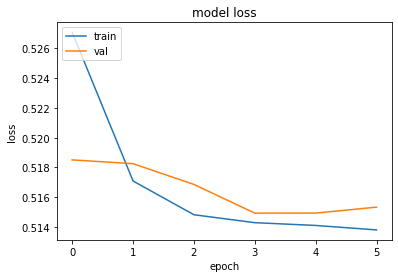

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('mc_model_higgs/loss.png')
plt.show()

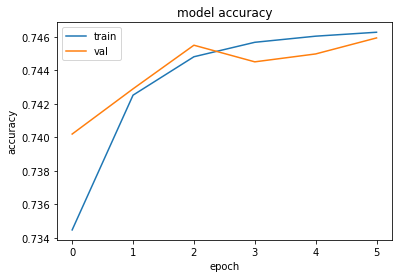

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('mc_model_higgs/accuracy.png')
plt.show()

## Performance plots

In [12]:
_, acc_s, precision_s, recall_s = mc_model.evaluate(test_dataset)

1719/1719 [==============================] - 4s 2ms/step - loss: 0.5103 - accuracy: 0.7465 - precision: 0.7641 - recall: 0.7515


In [13]:
T = 500
X = []
y_mc_pred = []
y_pred = []
y_pred_cls = []
y_true = []
for i, (X_i, y_i) in enumerate(tqdm.tqdm(test_dataset, total=1718)):
    mc_predictions_i = np.array([mc_model(X_i).numpy() for _ in range(T)])#.reshape((-1,))
    y_mc_pred.append(mc_predictions_i)
    y_pred_i = predictive_distribution(mc_predictions_i)
    y_pred.append(y_pred_i)
    y_pred_cls.append((y_pred_i > 0.5).astype(float))
    y_true.append(y_i.numpy())
    X.append(X_i)
    #if i == 50:
    #   break
X = np.concatenate(X)
y_mc_pred = np.concatenate(y_mc_pred, axis=1)
y_pred_cls = np.squeeze(np.concatenate(y_pred_cls))
y_pred = np.squeeze(np.concatenate(y_pred))
y_true = np.concatenate(y_true)

1719it [33:27,  1.17s/it]                                                                                                            


### Prediction Label distribution.

In [14]:
labels = [
    'Background',
    'Signal',
]

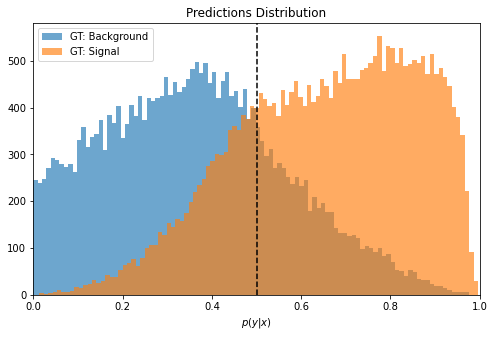

In [15]:
plt.figure(figsize=(8, 5))
plt.title('Predictions Distribution')
plt.axvline(x=0.5, c='k', ls='--')
for c in (0, 1):
    plt.hist(y_pred[y_true == c], label=f'GT: {labels[c]}', bins=100, alpha=0.65)
    plt.xlim([0,1])
plt.xlabel('$p(y|x)$')
plt.legend()
plt.savefig('mc_model_higgs/distribution.png')
plt.show()

### Classification Metrics

In [16]:
msg_1 = f'''Metrics for a single Fordward pass
Accuracy: {acc_s:.3f}
Recall: {recall_s:.3f}
Precision: {precision_s:.3f}'''
print(msg_1)

Metrics for a single Fordward pass
Accuracy: 0.746
Recall: 0.751
Precision: 0.764


In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
msg_2 = f'''Metrics for predictive distribution
Accuracy: {accuracy_score(y_true, y_pred_cls):.3f}
Recall: {recall_score(y_true, y_pred_cls):.3f}
Precision: {precision_score(y_true, y_pred_cls):.3f}'''
print(msg_2)

Metrics for predictive distribution
Accuracy: 0.760
Recall: 0.763
Precision: 0.778


In [18]:
from sklearn.metrics import classification_report

msg_3 = classification_report(y_true, y_pred_cls, target_names=labels)
print(msg_3)

              precision    recall  f1-score   support

  Background       0.74      0.76      0.75     25980
      Signal       0.78      0.76      0.77     29020

    accuracy                           0.76     55000
   macro avg       0.76      0.76      0.76     55000
weighted avg       0.76      0.76      0.76     55000



In [19]:
with open('mc_model_higgs/report.txt', 'w') as f:
    f.write(msg_1 + '\n\n')
    f.write(msg_2 + '\n\n')
    f.write(msg_3)

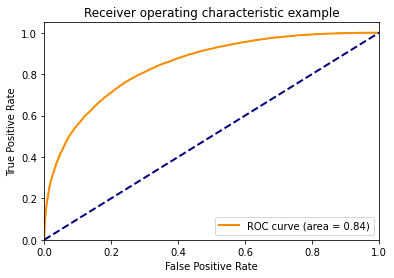

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.savefig('mc_model_higgs/ROC.png')
plt.show()

## Uncertainty

In [21]:
pred_entropy = predictive_entropy(y_pred.reshape((-1, 1)), normalize=True)
mut_information = mutual_information(y_pred.reshape((-1, 1)), y_mc_pred, normalize=True)

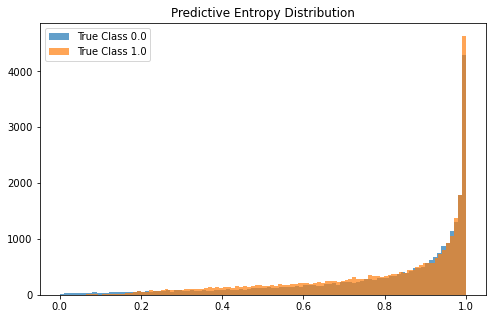

In [22]:
plt.figure(figsize=(8, 5))
plt.title('Predictive Entropy Distribution')
for c in (0., 1.):
    plt.hist(pred_entropy[y_true == c], label=f'True Class {c}', bins=100, alpha=0.7)
    #plt.xlim([0,1])
plt.legend()
plt.show()

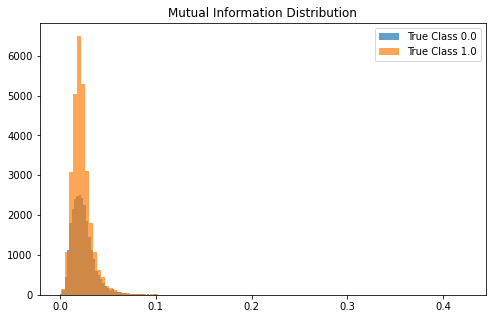

In [23]:
plt.figure(figsize=(8, 5))
plt.title('Mutual Information Distribution')
for c in (0., 1.):
    plt.hist(mut_information[y_true == c], label=f'True Class {c}', bins=100, alpha=0.7)
    #plt.xlim([0,1])
plt.legend()
plt.show()

## Save results

In [24]:
X_df = pd.DataFrame(X, columns=features_names)

y_df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'y_pred_cls': y_pred_cls,
    'predictive_entropy': pred_entropy,
    'mutual_information': mut_information,
})

In [25]:
X_df.to_csv('mc_model_higgs/X.csv', index=False)
y_df.to_csv('mc_model_higgs/y.csv', index=False)
np.save('mc_model_higgs/y_mc_pred', y_mc_pred)

## Sample

In [26]:
#idx = pred_entropy.argsort()[-1]
idx = mut_information.argsort()[-1]

In [27]:
pred_entropy[idx]

0.620653

In [28]:
mut_information[idx]

0.42347008

In [29]:
y_pred[idx]

0.84563655

In [30]:
y_true[idx]

1.0

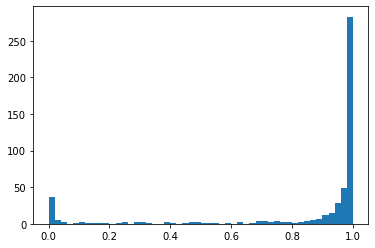

In [31]:
plt.hist(y_mc_pred[:, idx], bins=50);
#plt.xlim([0.,1.])